# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [3]:
import torch
from torchvision import datasets, transforms

In [4]:
x = datasets.MNIST('data', download=True)
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [7]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

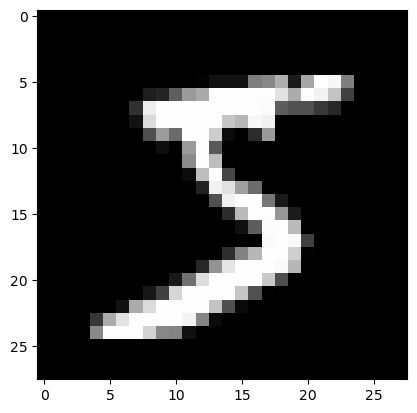

In [9]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

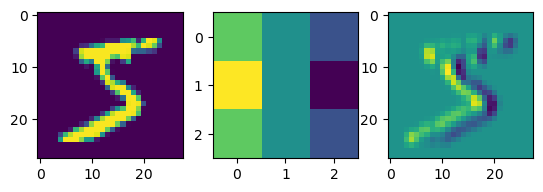

In [10]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [14]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

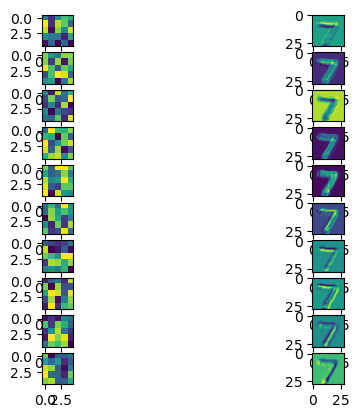

In [15]:
visualize()

# Predict Using Network

In [16]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [17]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 3, 7, 1, 5])

# First Test and Train

In [18]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [19]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 8%



In [20]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [21]:
train()

Train loss: 2.334467


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 1.578305
Train loss: 1.031746
Train loss: 0.796690
Train loss: 0.510007
Train loss: 0.557126
Train loss: 0.563968
Train loss: 0.691924
Train loss: 0.551781
Train loss: 0.470318


# Train Network

In [22]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.341714
Train loss: 1.853188
Train loss: 1.078657
Train loss: 0.988059
Train loss: 0.677395
Train loss: 0.607648
Train loss: 0.497385
Train loss: 0.677891
Train loss: 0.596354
Train loss: 0.473808
Test accuracy: 94%

Train loss: 0.445275
Train loss: 0.357541
Train loss: 0.326400
Train loss: 0.373244
Train loss: 0.356744
Train loss: 0.391962
Train loss: 0.328692
Train loss: 0.419141
Train loss: 0.337641
Train loss: 0.313737
Test accuracy: 96%

Train loss: 0.180709
Train loss: 0.210543
Train loss: 0.217056
Train loss: 0.253070
Train loss: 0.214520
Train loss: 0.301125
Train loss: 0.282295
Train loss: 0.429494
Train loss: 0.391525
Train loss: 0.449898
Test accuracy: 97%

Train loss: 0.122415
Train loss: 0.236972
Train loss: 0.241788
Train loss: 0.314890
Train loss: 0.108693
Train loss: 0.185458
Train loss: 0.154549
Train loss: 0.300300
Train loss: 0.361474
Train loss: 0.337129
Test accuracy: 97%

Train loss: 0.213176
Train loss: 0.203808
Train loss: 0.215285
Train loss: 0.415

# Inspect Network

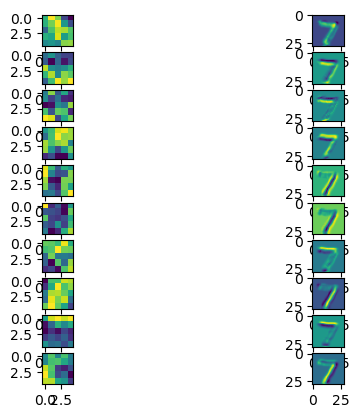

In [23]:
visualize()

In [24]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [25]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

## Setting a Seed to Allow Data Reproduction

In [26]:
torch.manual_seed(42)

## 60,000 Images
- Accuracy approaches 98%

In [27]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [28]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.326698
Train loss: 2.202992
Train loss: 1.548707
Train loss: 0.965259
Train loss: 0.733214
Train loss: 0.584287
Train loss: 0.587423
Train loss: 0.651645
Train loss: 0.575186
Train loss: 0.580905
Test accuracy: 93%

Train loss: 0.435604
Train loss: 0.491514
Train loss: 0.323234
Train loss: 0.561043
Train loss: 0.408683
Train loss: 0.410986
Train loss: 0.284992
Train loss: 0.387664
Train loss: 0.454853
Train loss: 0.421125
Test accuracy: 96%

Train loss: 0.293261
Train loss: 0.242441
Train loss: 0.330508
Train loss: 0.338163
Train loss: 0.201573
Train loss: 0.496916
Train loss: 0.158809
Train loss: 0.386033
Train loss: 0.235530
Train loss: 0.549762
Test accuracy: 97%

Train loss: 0.210935
Train loss: 0.105798
Train loss: 0.182116
Train loss: 0.314826
Train loss: 0.138307
Train loss: 0.234971
Train loss: 0.290094
Train loss: 0.340712
Train loss: 0.410363
Train loss: 0.488350
Test accuracy: 97%

Train loss: 0.176494
Train loss: 0.190522
Train loss: 0.157995
Train loss: 0.131

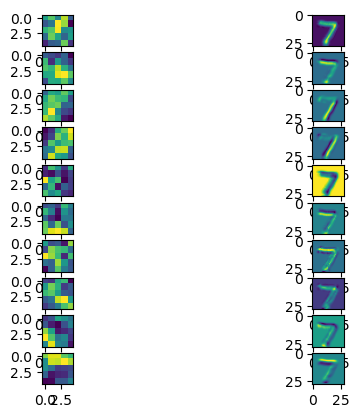

In [29]:
visualize()

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [31]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.324687
Train loss: 1.741514
Train loss: 1.066642
Train loss: 0.713492
Train loss: 0.612382
Test accuracy: 92%

Train loss: 0.651417
Train loss: 0.393351
Train loss: 0.304230
Train loss: 0.481259
Train loss: 0.579608
Test accuracy: 95%

Train loss: 0.331348
Train loss: 0.380232
Train loss: 0.218719
Train loss: 0.535686
Train loss: 0.233754
Test accuracy: 96%

Train loss: 0.413175
Train loss: 0.385485
Train loss: 0.348863
Train loss: 0.494746
Train loss: 0.403591
Test accuracy: 97%

Train loss: 0.151079
Train loss: 0.247274
Train loss: 0.210605
Train loss: 0.495494
Train loss: 0.149599
Test accuracy: 97%



## 30,000 Images
- Accuracy approaches 97%

In [32]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6,000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [33]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%



## 6,000 Images
- Accuracy approaches 10%

In [34]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3,000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [35]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%

Test accuracy: 10%



## 3,000 Images
- Accuracy approaches 10%

In [39]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [40]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

Train loss: 2.297172


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_34860/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 9%

Train loss: 2.283719
Test accuracy: 10%

Train loss: 2.288454
Test accuracy: 14%

Train loss: 2.257553
Test accuracy: 25%

Train loss: 2.273012
Test accuracy: 30%



## 600 images
- Accuracy approaches 3%

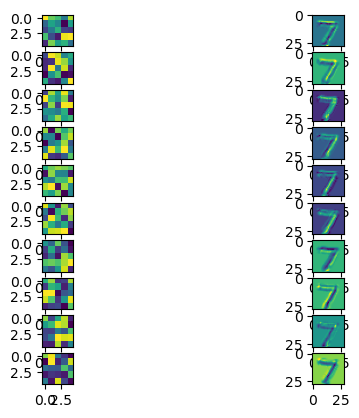

In [41]:
visualize()

Using 60,000 images as training data, the weights appear to cluster strongly in one location following training, while with only 600 images, the weights do not appear to change significantly throughout training, remaining spread approximately randomly.